In [1]:
import os, sys
HOME_DIR = os.path.join(os.getcwd(), '..')
sys.path.append(HOME_DIR)
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
import torch
from torch_geometric.loader import DataLoader
from substrate_metric_learning.networks import Net
from substrate_metric_learning.utils import *
from substrate_metric_learning.features import smiles_to_graph_substrate, smiles_to_graph
from rdkit.Chem import Draw
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn import manifold
from umap import UMAP

/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/dist

In [2]:
config_path = os.path.join(HOME_DIR, "configs/hparams_default.yaml")
config = Objdict(yaml.safe_load(open(config_path)))
input_dim = 133
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1.172
model_pretrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_pretrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_56_sum_r2_1.538.pth"))
model_untrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_untrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_0.pth"))

<All keys matched successfully>

In [3]:
data_buyable = pd.read_csv("../data/buyable_aryl_bromides.csv")
data_buyable

,smiles,c_index,x_index,in_doyle
0,BrC1=CC=C(C=O)C=C1,1,0,False
1,BrC1=CC=CC=C1,1,0,False
2,CC(=O)C1=CC=C(Br)C=C1,6,7,False
3,COC1=CC=C(Br)C=C1,5,6,False
4,CC1=CC=C(Br)C=C1,4,5,False
...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,5,False
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,1,0,False
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,8,9,False
2679,CC1=CC(Br)=CC(=C1)C(F)F,3,4,False


In [5]:
embedding_buyable = get_embedding_from_smi(
    data_buyable.smiles.to_list(),
    data_buyable.c_index.to_list(),
    model_pretrained,
    device
)

/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


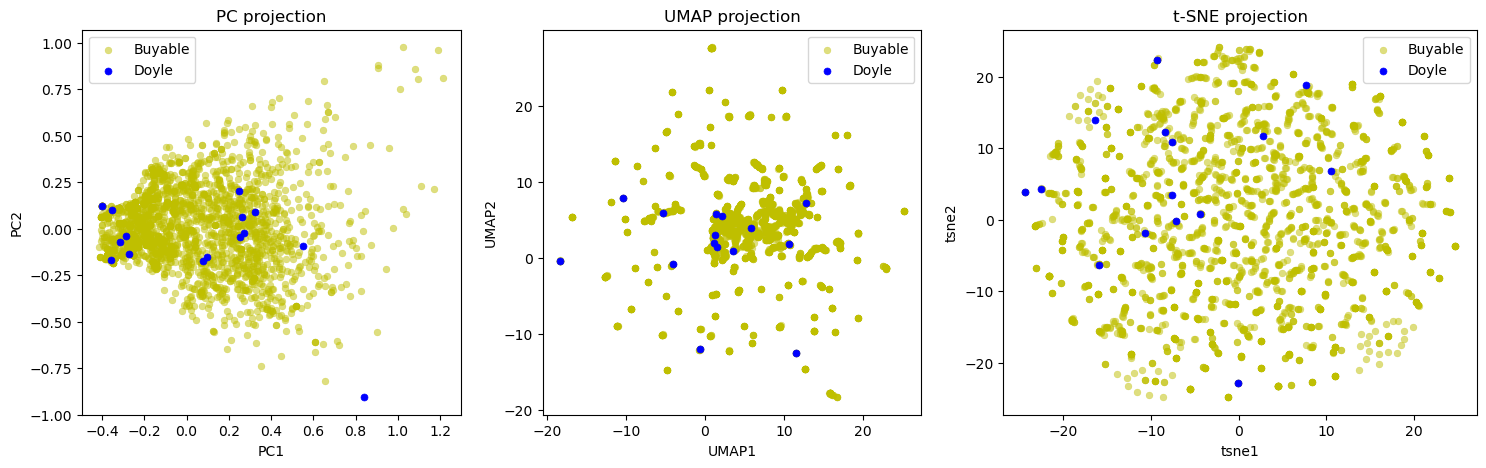

In [6]:
dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embedding_buyable.shape[1]))

key = f"umap{dim}"
n_neighbors = 6
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors, random_state=8).fit_transform(embedding_buyable), index=data_buyable.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=8,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embedding_buyable), index=data_buyable.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embedding_buyable), index=data_buyable.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

# scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = data_buyable.in_doyle.to_list()
# c_list = None

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']

_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='y', edgecolor='face', ax=ax[0], label="Buyable").set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='y', edgecolor='face', ax=ax[1], label="Buyable").set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='y', edgecolor='face', ax=ax[2], label="Buyable").set_title("t-SNE projection")

_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='b', edgecolor='face', ax=ax[0], label="Doyle").set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='b', edgecolor='face', ax=ax[1], label="Doyle").set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='b', edgecolor='face', ax=ax[2], label="Doyle").set_title("t-SNE projection")

# norm = plt.Normalize(0, 1)
# sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
# sm.set_array([])

# Remove the legend and add a colorbar
# print(scope_id2ind)
# ax[2].figure.colorbar(sm)
plt.legend()
plt.show()

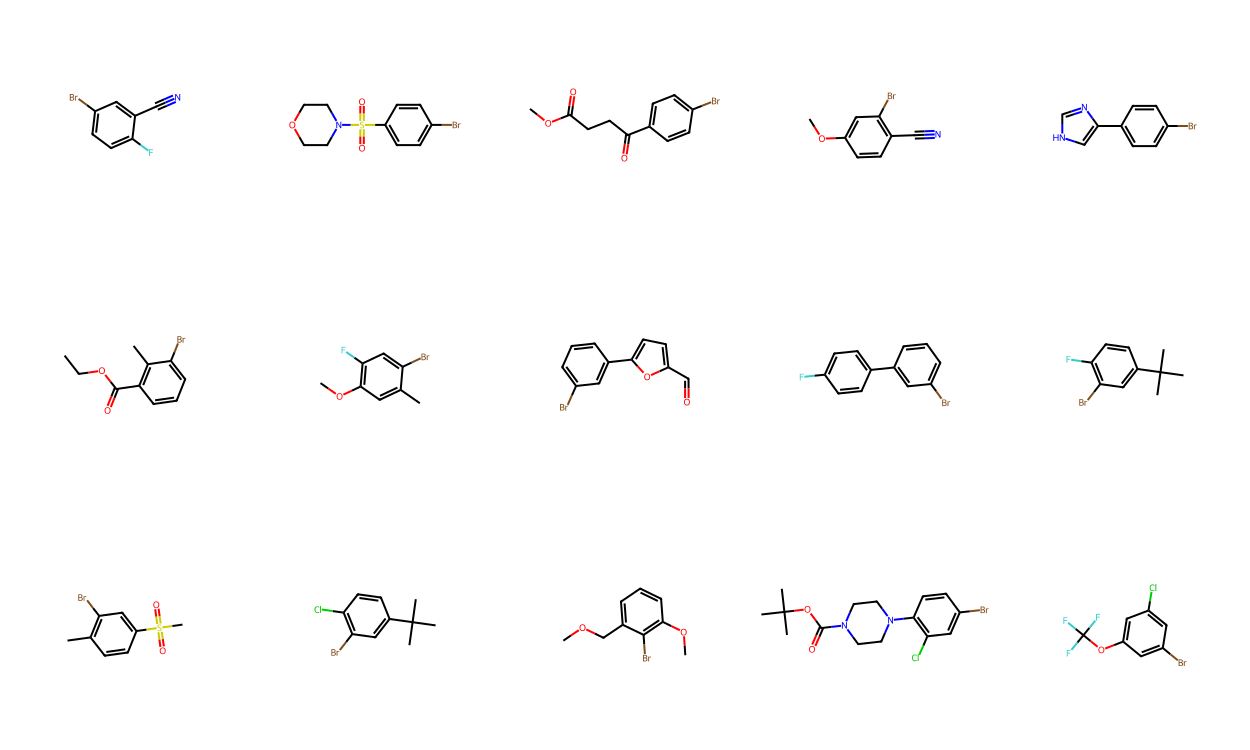

In [41]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in data_buyable[data_buyable['in_doyle'] == True].smiles.to_list()], molsPerRow=5,subImgSize=(250,250),useSVG=True)

In [23]:
from DiverseSelector.methods.partition import *
from DiverseSelector.methods.dissimilarity import *
from sklearn.metrics import pairwise_distances

In [93]:
# t_sne = manifold.TSNE(
#     n_components=2,
#     perplexity=8,
#     init="random",
#     n_iter=350,
#     random_state=0,
# )
# t_sne_features = t_sne.fit_transform(embedding_buyable)

# selector = MaxMin()
# dist = pairwise_distances(X=t_sne_features, metric="l2")
# # dist = pairwise_distances(X=embedding_buyable, metric="l1")
# selected_id = selector.select(arr=dist, size=15)

selected_id = GridPartitioning(2, "equisized_independent").select(embedding_buyable, 15)

data_buyable['maxmin'] = False
data_buyable.loc[selected_id, 'maxmin'] = True

TypeError: hypersphere_overlap_of_subset() missing 1 required positional argument: 'x'

/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


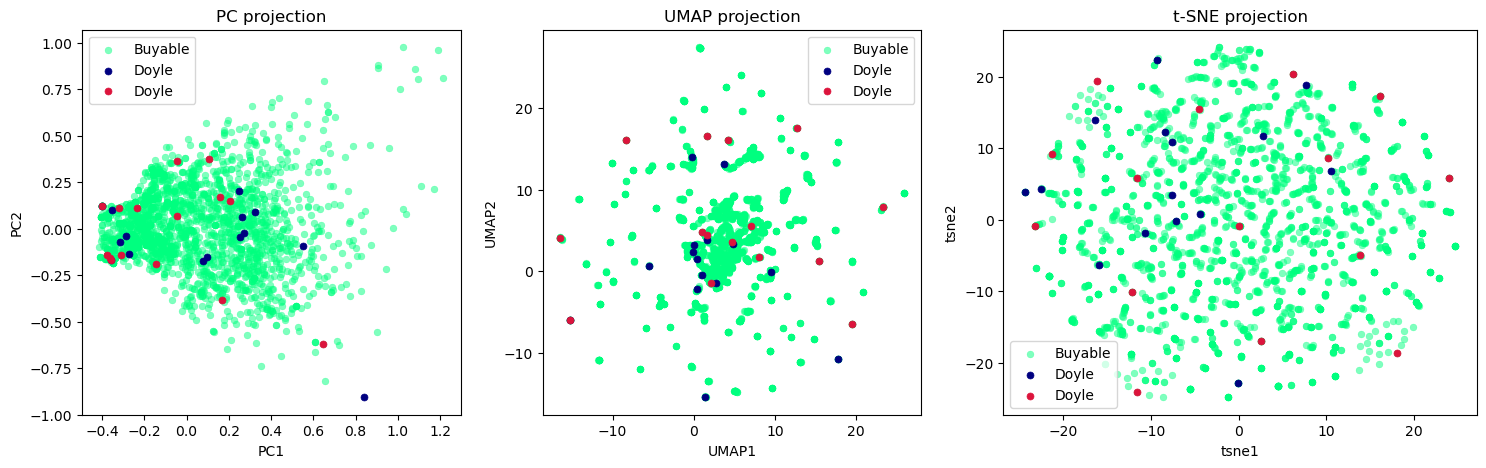

In [90]:
dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embedding_buyable.shape[1]))

key = f"umap{dim}"
n_neighbors = 6
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors, random_state=8).fit_transform(embedding_buyable), index=data_buyable.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=8,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embedding_buyable), index=data_buyable.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embedding_buyable), index=data_buyable.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']

_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='springgreen', edgecolor='face', ax=ax[0], label="Buyable").set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='springgreen', edgecolor='face', ax=ax[1], label="Buyable").set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='springgreen', edgecolor='face', ax=ax[2], label="Buyable").set_title("t-SNE projection")

_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='navy', edgecolor='face', ax=ax[0], label="Doyle").set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='navy', edgecolor='face', ax=ax[1], label="Doyle").set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='navy', edgecolor='face', ax=ax[2], label="Doyle").set_title("t-SNE projection")

_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'][data_buyable.maxmin], s=25, alpha=1.0, linewidth=0.5, c='crimson', edgecolor='face', ax=ax[0], label="Doyle").set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'][data_buyable.maxmin], s=25, alpha=1.0, linewidth=0.5, c='crimson', edgecolor='face', ax=ax[1], label="Doyle").set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][data_buyable.maxmin], s=25, alpha=1.0, linewidth=0.5, c='crimson', edgecolor='face', ax=ax[2], label="Doyle").set_title("t-SNE projection")

# norm = plt.Normalize(0, 1)
# sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
# sm.set_array([])

# Remove the legend and add a colorbar
# print(scope_id2ind)
# ax[2].figure.colorbar(sm)
plt.legend()
plt.show()

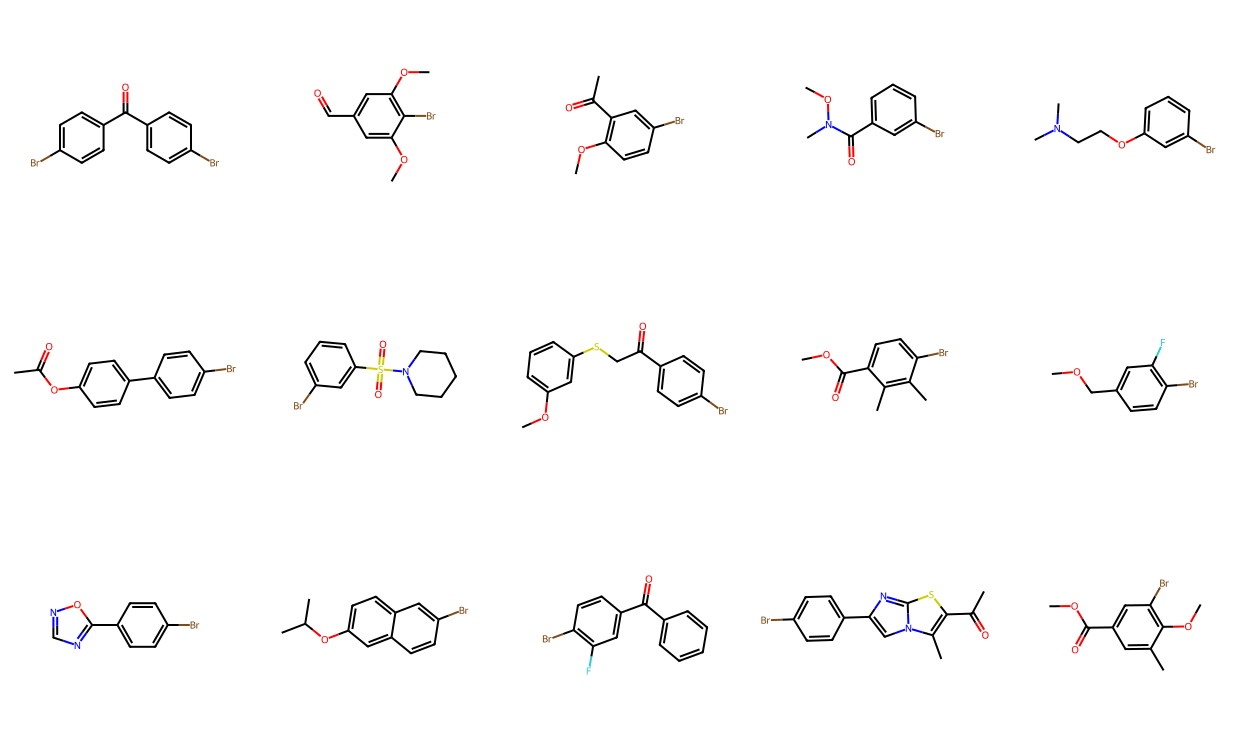

In [91]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in data_buyable[data_buyable['maxmin'] == True].smiles.to_list()], molsPerRow=5,subImgSize=(250,250),useSVG=True)

In [94]:
from DiverseSelector.diversity import *

In [ ]:
gini_coefficient